In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

9774
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# --- Launch to change cells' width ---
import pylib.mix as mix
import pylib.qucf_read as qucf_r
import pylib.qucf_oracle as qucf_o
import pylib.qucf_matrix_D as qucf_m
import ASE as ase
import pylib.qsvt_angles as qsvt_a
import pylib.Chebyschev_coefs as ch
import cvxpy as cp

colors_ = ["b", "r", "g", "magenta", "black"]
path_angles_ = "../QuCF/simulations/EVM/vH-angles/"

for i in range(30):
    plt.close()

In [3]:
# ---------------------------------------------------------------
# --- Read data ---
# ---------------------------------------------------------------
mix.reload_module(ase)

print("\n--- Creating the object with data... ---")
data_ = ase.ASE_()

print("\n--- Reading matrices D from quantum simulations ---")
data_.read_D_matrices()

print("\n\n--- Reading matrices of the considered 1D kinetic problem --") 
data_.read_plasma_matrices()

print("--- Creating a template to extrapolate the matrix D for larger sizes ---") 
data_.create_D_template()


--- Creating the object with data... ---

--- Reading matrices D from quantum simulations ---

Reading the matrix from: flat_33_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/matrices-D/
date of the simulation:  06-06-2023 09:51:13
matrix name:  U_BE
N = 128

Reading the matrix from: flat_44_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/matrices-D/
date of the simulation:  06-06-2023 08:57:47
matrix name:  U_BE
N = 512

Reading the matrix from: flat_45_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/matrices-D/
date of the simulation:  06-23-2023 15:42:09
matrix name:  U_BE
N = 1024

Reading the matrix from: flat_54_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/matrices-D/
date of the simulation:  06-23-2023 15:48:52
matrix name:  U_BE
N = 1024


--- Reading matrices of the considered 1D kinetic problem --

Reading data from out_3_3_w1.2_Lx100_Lv4_flat.hdf5...
date of the simulation:  06-22-2023 15:48:52
N, nx, nv = 128, 3, 3
Done.

Reading data from out_4_4_w1.2_Lx10

In [4]:
# --------------------------------------------------------------------
# --- Choose a case (matrix size) with which you are going to work ---
# --------------------------------------------------------------------
data_.choose_a_case(nx = 4, nv = 4)

original matrix >>>
amax. value: 			4.000e+00
amin.(excl. zero) value: 	2.855e-04

norm of the matrix:  9.907124260405292

normalized matrix >>>
amax. value: 			3.552e-03
amin.(excl. zero) value: 	2.535e-07



<IPython.core.display.Javascript object>


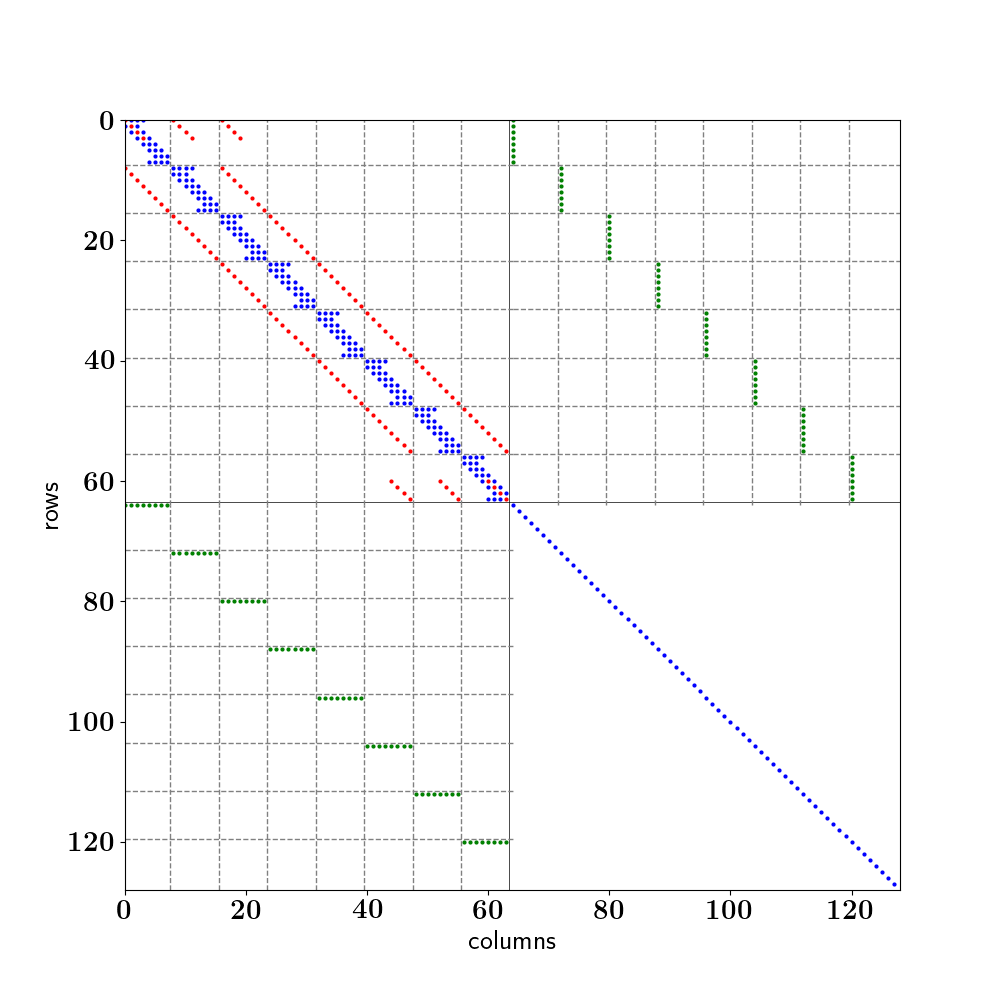

In [9]:
# ---------------------------------------------------------------
# --- Plot the original matrix indicating its structure ---
# ---------------------------------------------------------------
_ = ase.plot_colored_A_structure(
    data_.Nx_work_, data_.Nv_work_, 
    data_.BF_fixed_, data_.BF_prof_, data_.B_CE_, data_.B_Cf_, data_.BS_,
    flag_save = False, 
    path_save = data_.path_save_, 
    fontsize = 20, 
    cmap='bwr'
)

In [56]:
# ---------------------------------------------------------------
# --- Compute parameters for submatrices ---
# ---------------------------------------------------------------
mix.reload_module(ase)
ase.preliminary_parameters_for_submatrices(data_)

nx 4
nv 4
Nvhm1 7
Nxm2 14
Nxm4 12

//--- Parameters for the submatrix Cf ---
alpha_0_cf 	-2.841788633538e-02
alpha_1_cf 	3.031241209107e-02

//--- Parameters for the oracle for the submatrix CE ---
alpha_0_CE 	-1.000000000000e+00
alpha_1_CE 	1.066666666667e+00

//--- Parameters for the submatrix S ---
angle_sb 	-0.002131341879
angle_se 	-0.002131344299

//--- Parameters for the submatrix F-prof ---

//- diag 0: left edge -
a0_FB0_L 	-0.018367610748
a1_FB0_L 	0.009645350465
a0_FB0_iw_L 	-0.048227920803

//- diag 0: right edge -
a0_FB0_R 	-0.002104699707
a1_FB0_R 	-0.013640585441
a0_FB0_iw_R 	-0.068206232381

//- diag -1 -
alpha_0_LFB1 	-0.002131341475
alpha_1_LFB1 	0.002273430907

alpha_0_LFB1_corr1 	-3.014172020211e-03
alpha_1_LFB1_corr1 	1.607558410779e-03
alpha_0_LFB1_corr1_2 	1.420894316769e-04
alpha_1_LFB1_corr1_2 	1.136715453415e-03

alpha_0_LFB1_corr2 	-2.131341475154e-03
alpha_1_LFB1_corr2 	1.136715453415e-03
alpha_0_LFB1_corr2_2 	-2.841788633538e-04
alpha_1_LFB1_corr2_2 	-2.273

In [30]:
# ---------------------------------------------------------------
# --- Recheck the submatrices --
# ---------------------------------------------------------------
mix.reload_module(ase)
ase.recheck_QuCF_submatrices(data_)

Reading the matrix from: BE_final_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/
date of the simulation:  03-03-2024 11:07:36
matrix name:  U_BE
N = 512

--- Cf: QuCF version vs original version ---
The same size of the matrices.
N of nonzero elements = 256
Max. abs. error: 4.781e-07

--- CE: QuCF version vs original version ---
The same size of the matrices.
N of nonzero elements = 256
Max. abs. error: 4.115e-08

--- S: QuCF version vs original version ---
The same size of the matrices.
N of nonzero elements = 256
Max. abs. error: 2.175e-13


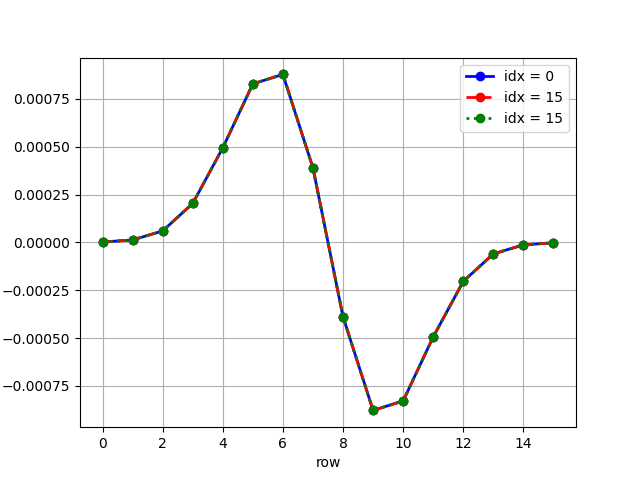

In [6]:
# ---------------------------------------------------------------------------
# --- Submatrix CE: Compare various x ---
# ---------------------------------------------------------------------------
def get_values_at_x1(id_x, values_CE):
    res_values = values_CE[id_x*data_.Nv_work_:(id_x+1)*data_.Nv_work_]
    rows = np.array(range(data_.Nv_work_))
    return res_values, rows
    
# --- Compare various x ---
def compare_profiles_CE():
    ids_x = [0, 15, data_.Nx_work_-1]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    lines = ["-", "--", ":", ":", ":"]
    for ii in range(len(ids_x)):
        id_x = ids_x[ii]
        diag_1, rows_1 = get_values_at_x1(id_x, CE_values)
        ax.plot(
            rows_1, diag_1.real, 
            color=colors_[ii], marker = "o", linewidth = 2, linestyle=lines[ii],
            label= "idx = {:d}".format(id_x)
        )
    plt.xlabel('row')
    plt.ylabel("data")
    plt.legend()
    plt.grid(True)
    plt.show()
    del ids_x, diag_1, rows_1
# -----------------------------------------------------------------
CE_values = data_.B_CE_.get_values()
compare_profiles_CE()

Max. error: 2.642e-06


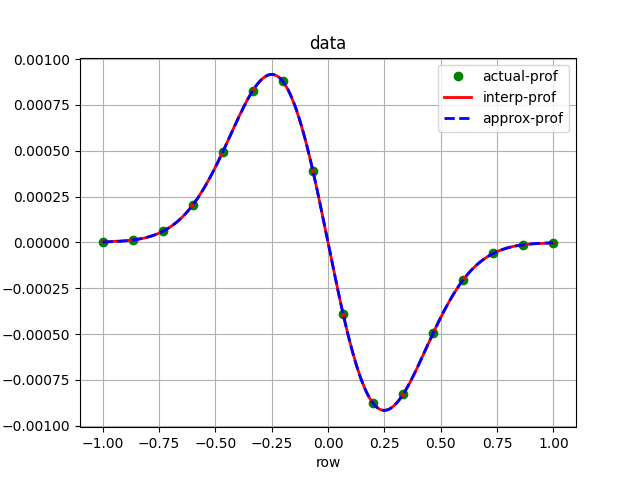

Chosen profile: prof_CE
Chosen parity: 1

Minimization method is used.
Computation status:  4.2438448198369013e-11

x[0] =  -1.0
x[-1] =  1.0
Chosen polynomial's degree:	 16
Number of coefficients:		 8
max. abs. error: 9.256e-07


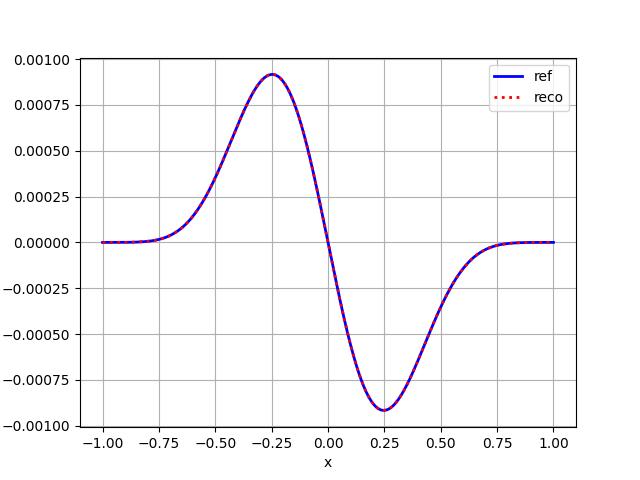

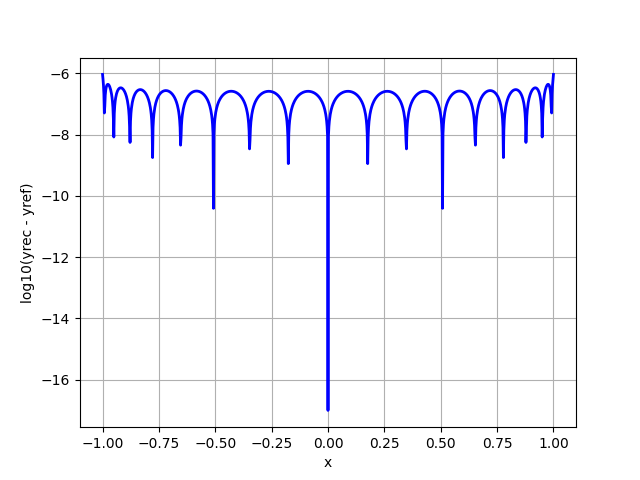

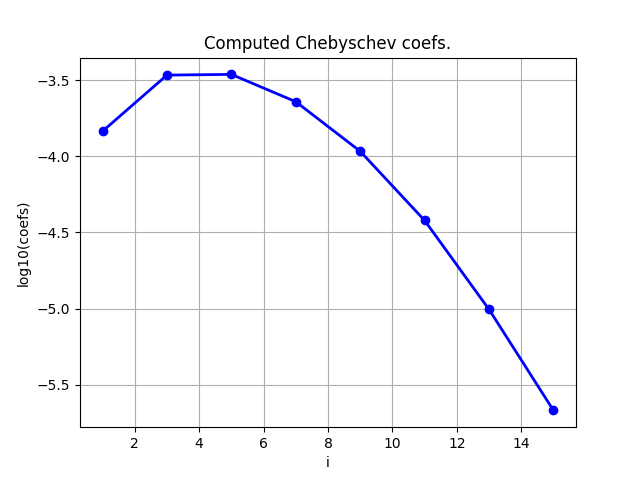

write angles to:
 ../QuCF/simulations/EVM/vH-angles//prof_CE__eps6.hdf5


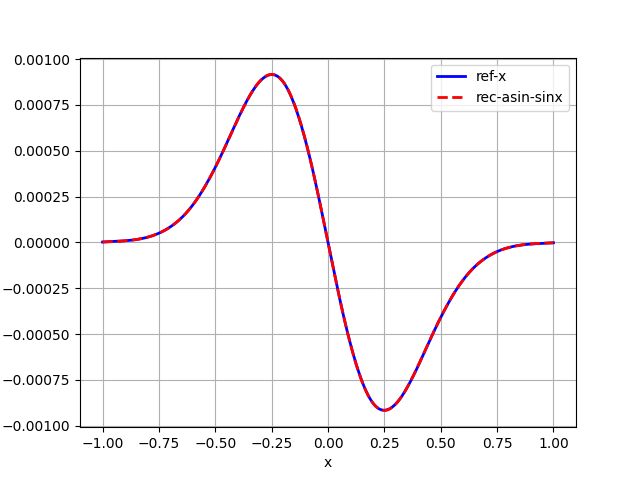

In [24]:
# -----------------------------------------------------------------------
# --- Compute the Chebyschev coefficients for the CE profile ---
# -----------------------------------------------------------------------
mix.reload_module(ch)
from scipy.interpolate import CubicSpline
from scipy.optimize import least_squares
import math

def approximate_profiles_CE():
    # ---------------------------------------------------------------------------
    def compute_Cheb_coefs(diag_ch, name_prof_1, parity_1, Nd, flag_save_hdf5):
        # v_grid_norm = np.array(data_.B_Cf_.get_slice(0,0, data_.Nv_work_).get_values().real)

        sel_method = 0

        oo_ch_ = ch.Ch_()
        oo_ch_.choose_method(sel_method)
        oo_ch_.choose_func(
            -1, 0.0, 
            profile_in = diag_ch,
            name_prof  = name_prof_1,
            parity_in  = parity_1,
            path_root_in = path_angles_,
            # x_grid = v_grid_norm
            x_grid = x_grid_gl
        )
        oo_ch_.compute_Ch(Nd)
        oo_ch_.plot_reconstructed_function()
        oo_ch_.plot_errors()
        oo_ch_.plot_coefficients()

        if flag_save_hdf5:
            oo_ch_.save_coefficients()
        return oo_ch_
    
    def approx_vH(par, x):
        return par[1] * x * np.exp(par[0] * x**2)
    
    def approx_vH_asin(par, x):
        y = np.arcsin(x)
        return par[1] * y * np.exp(par[0] * y**2)
    
    def comp_residual(par):
        res = np.sum(np.abs(values_vH - approx_vH(par, x_grid_gl)))
        return [res]
    # ---------------------------------------------------------------------------
    diag_1, _ = get_values_at_x1(0, CE_values)
    values_vH_orig = np.array(diag_1.real) * (2**data_.nv_work_/2)
    x_grid_orig  = np.linspace(-1.0, 1.0, len(values_vH_orig))

    spl = CubicSpline(x_grid_orig, values_vH_orig)

    x_grid_gl  = np.linspace(-1.0, 1.0, 1001)
    values_vH = spl(x_grid_gl)

    # --- Find the approximation approximation ---
    res_approx = least_squares(comp_residual, [-8.0, -6.091e-03], xtol=1e-14)
    coefs = res_approx.x

    approx_values_vH = approx_vH(coefs, x_grid_gl)
    print("Max. error: {:0.3e}".format(
        np.max(np.abs(
            approx_values_vH - values_vH
        ))
    ))

    # --- Check approximation ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        x_grid_orig, values_vH_orig, 
        marker = "o",  color='g', linewidth = 2, linestyle='None',
        label="actual-prof"
    )
    ax.plot(
        x_grid_gl, values_vH,        
        color='r', linewidth = 2, linestyle='-',
        label="interp-prof"
    )
    ax.plot(
        x_grid_gl, approx_values_vH, 
        color='b', linewidth = 2, linestyle='--',
        label="approx-prof"
    )
    plt.xlabel('row')
    plt.title("data")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Compute the Chebyschev coefficients ---
    Nd = 16
    oo_ch = compute_Cheb_coefs(
        approx_vH(
            coefs, 
            np.arcsin(x_grid_gl)
        ), 
        "prof_CE", 1, Nd, 
        flag_save_hdf5 = True
    )

    # --- Plot f_Ch(sin(x)) ---
    y_rec_sin_x = oo_ch.get_rec_y_sin_x(x_grid_gl)
    y_rec_x = oo_ch.get_rec_y_x(x_grid_gl)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_grid_gl, values_vH, "-",  color="b", linewidth = 2, label = "ref-x")
    ax.plot(x_grid_gl, y_rec_sin_x, "--", color="r", linewidth = 2, label = "rec-asin-sinx")
    # ax.plot(x_grid_gl, y_rec_x, "--", color="g", linewidth = 2, label = "rec-asin-x")
    # ax.plot(x_grid_gl, approx_vH_asin(coefs, np.sin(x_grid_gl)), 
    #         ":", color="black", linewidth = 2, 
    #         label = "apprx-asin-sinx"
    # )
    # ax.plot(x_grid_gl, approx_vH_asin(coefs, x_grid_gl), 
    #         ":", color="black", linewidth = 2, 
    #         label = "apprx-asin-x"
    # )
    plt.xlabel('x')
    plt.ylabel("diag")
    plt.legend()
    plt.grid(True)
    plt.show() 

# -----------------------------------------------------------------
approximate_profiles_CE()

Reading the matrix from: BE_final_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/
date of the simulation:  03-03-2024 10:52:07
matrix name:  U_BE
N = 512


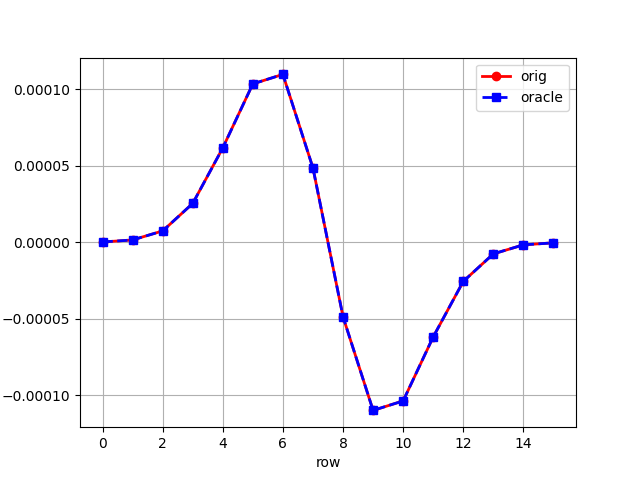

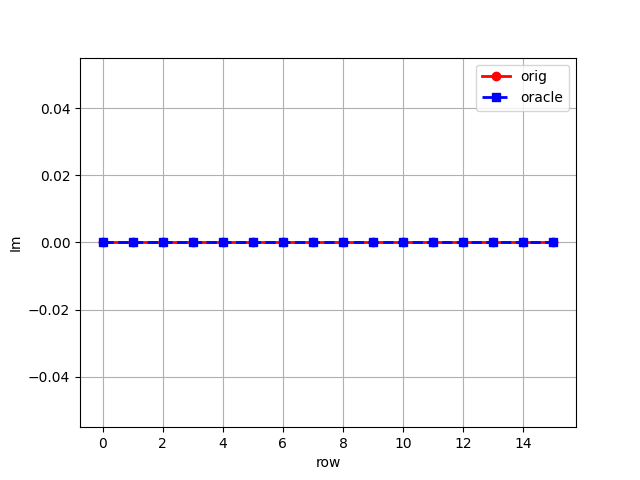

maximum rel. eror: 3.748e-04


In [27]:
# -----------------------------------------------------------------------------
# --- Submatrix CE: read results from QuCF simulations ---
# -----------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qsvt_a)

id_x = 0

# data from oralce constructor:
CE_values = data_.CE_orig_.get_values()
diag_orig, rows_orig = get_values_at_x1(0, CE_values)

# data from QuCF simulations:
dd_qucf = qucf_r.read_matrix_sparse(data_.path_qc_, data_.output_qucf_) 
CE_recon = dd_qucf["A"].get_slice(0, data_.Nvar_work_, data_.Nvar_work_).get_values()
diag_qucf, rows_qucf = get_values_at_x1(0, CE_recon)

# --- Re ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    rows_orig, diag_orig.real, 
    marker = "o", color='r', linewidth = 2, linestyle='-',
    label = "orig"
)
ax.plot(
    rows_qucf, diag_qucf.real, 
    marker = "s", color='b', linewidth = 2, linestyle='--',
    label = "oracle"
)
plt.xlabel('row')
plt.ylabel("Re")
plt.legend()
plt.grid(True)
plt.show()

# --- Im ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    rows_orig, diag_orig.imag, 
    marker = "o", color='r', linewidth = 2, linestyle='-',
    label = "orig"
)
ax.plot(
    rows_qucf, diag_qucf.imag, 
    marker = "s", color='b', linewidth = 2, linestyle='--',
    label = "oracle"
)
plt.xlabel('row')
plt.ylabel("Im")
plt.legend()
plt.grid(True)
plt.show()

# --- maximum error ---
norm_coef = np.max(np.abs(diag_orig.real))
print("maximum rel. eror: {:0.3e}".format(
    np.max(np.abs(diag_orig.real/norm_coef - diag_qucf.real/norm_coef))
))


del id_x

In [33]:
for i in range(30):
    plt.close()

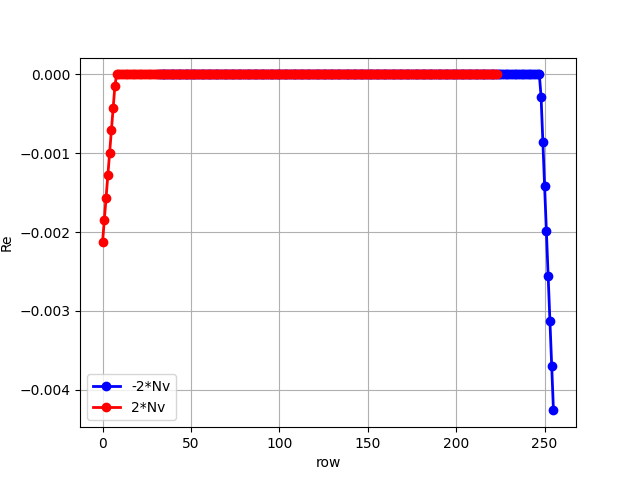

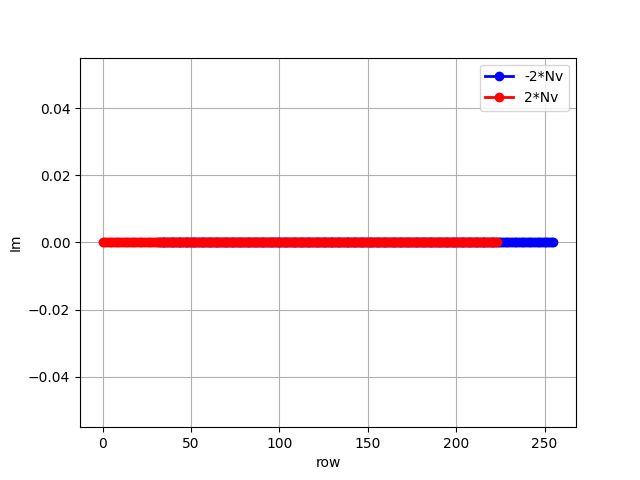

In [5]:
# ---------------------------------------------------------------------------
# --- Print profiles in the submatrix F-PROFILES ---
# ---------------------------------------------------------------------------
mix.reload_module(ase)
def get_diag(A, i_shift):
    N = A.shape[0]
    diag = np.zeros(N-np.abs(i_shift), dtype=A.dtype)
    if i_shift >= 0:
        chosen_range = range(N-i_shift)
        for ir in range(N-i_shift):
            diag[ir] = A[ir, ir + i_shift]
    else:
        chosen_range = range(-i_shift, N)
        for ir in chosen_range:
            diag[ir + i_shift] = A[ir, ir + i_shift]
    row_range = np.array(chosen_range)
    return diag, row_range

# ----------------------------------------------------------
def plot_diags_F_profs():
    data_shifts = []
    data_shifts.append([-2*data_.Nv_work_, "-2*Nv"])
    data_shifts.append([2*data_.Nv_work_, "2*Nv"])

    # data_shifts = []
    # data_shifts.append([-data_.Nv_work_, "-Nv"])
    # data_shifts.append([data_.Nv_work_, "Nv"])

    # data_shifts = []
    # data_shifts.append([0, "0"])


    # --- Real parts ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i_shifts in range(len(data_shifts)):
        dd1 = data_shifts[i_shifts]
        diag_1, rows_1 = get_diag(BFP, dd1[0])
        ax.plot(
            rows_1, diag_1.real, 
            color=colors_[i_shifts], marker = "o", linewidth = 2, linestyle='-',
            label=dd1[1]
        )
    plt.xlabel('row')
    plt.ylabel("Re")
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Imaginary parts ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i_shifts in range(len(data_shifts)):
        dd1 = data_shifts[i_shifts]
        diag_1, rows_1 = get_diag(BFP, dd1[0])
        ax.plot(
            rows_1, diag_1.imag, 
            color=colors_[i_shifts], marker = "o", linewidth = 2, linestyle='-',
            label=dd1[1]
        )
    plt.xlabel('row')
    plt.ylabel("Im")
    plt.grid(True)
    plt.legend()
    plt.show()
    return

# -----------------------------------------------------------------------------------------------
# --- data from the oracle constructor ---
BFP = data_.BF_prof_.form_dense_matrix() # of size Nv*Nx;
plot_diags_F_profs()


Reading the matrix from: BE_OUTPUT.hdf5
from the path: ../QuCF/simulations/EVM/
date of the simulation:  03-05-2024 21:23:27
matrix name:  U_BE
N = 512
max. rel. err: 4.945e-01


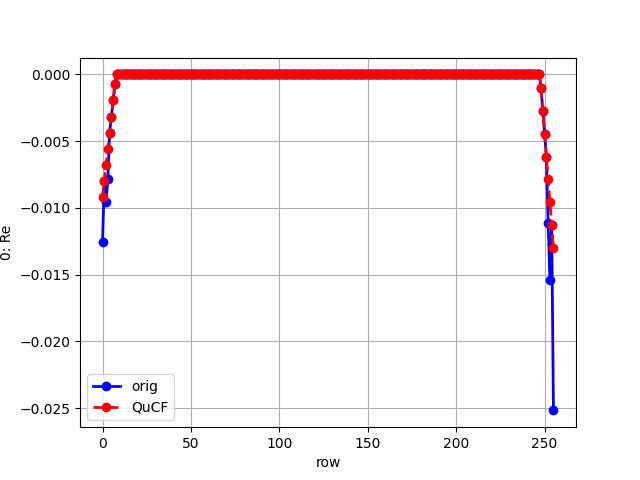

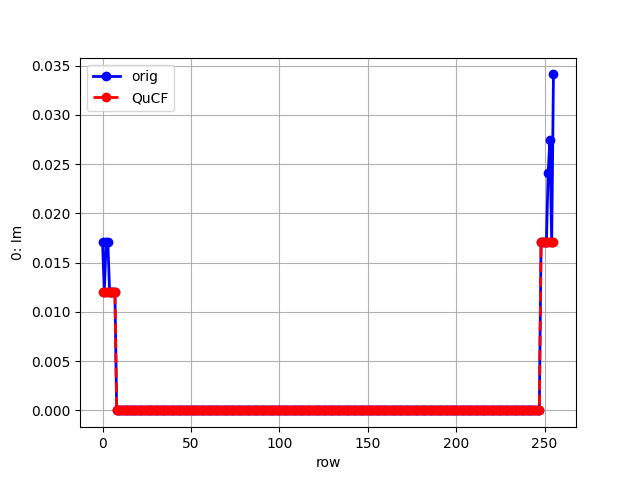

In [6]:
# ---------------------------------------------------------------------------
# --- F-PROFILES: comparison with the QuCF simulation ---
# ---------------------------------------------------------------------------
mix.reload_module(ase)
def comparison_FPROF_with_QuCF():
    # shift_diag, label_diag = -2*data_.Nv_work_, "-2*Nv"
    # shift_diag, label_diag = -data_.Nv_work_, "-Nv"
    shift_diag, label_diag =   0, "0"
    # shift_diag, label_diag =   data_.Nv_work_, "Nv"
    # shift_diag, label_diag = 2*data_.Nv_work_, "2*Nv"

    # --- original data ---
    diag_1, rows_1 = get_diag(BFP, shift_diag)

    # --- data from QuCF simulations ---
    dd_qucf = qucf_r.read_matrix_sparse(data_.path_qc_, data_.output_qucf_) 
    F_recon = dd_qucf["A"].get_slice(0, 0, data_.Nvar_work_)
    _, BFP_recon = ase.extract_fixed_profile_matrix_from_F(
        data_.nx_work_, data_.nv_work_, F_recon, data_.DF_work_
    )
    BFP_recon = BFP_recon.form_dense_matrix()
    diag_2, rows_2 = get_diag(BFP_recon, shift_diag)
    del dd_qucf, F_recon

    # --- Maximum relative error ---
    norm_coef = np.max(np.abs(diag_1))
    print("max. rel. err: {:0.3e}".format(
        np.max(np.abs(diag_2 - diag_1)/norm_coef)
    ))

    # --- Real parts ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        rows_1, diag_1.real, 
        marker = "o", color='b', linewidth = 2, linestyle='-',
        label = "orig"
    )
    ax.plot(
        rows_2, diag_2.real, 
        marker = "o", color='r', linewidth = 2, linestyle='--',
        label = "QuCF"
    )
    plt.xlabel('row')
    plt.ylabel(label_diag + ": Re")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Imaginary parts ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        rows_1, diag_1.imag, 
        marker = "o", color='b', linewidth = 2, linestyle='-',
        label = "orig"
    )
    ax.plot(
        rows_2, diag_2.imag, 
        marker = "o", color='r', linewidth = 2, linestyle='--',
        label = "QuCF"
    )
    plt.xlabel('row')
    plt.ylabel(label_diag + ": Im")
    plt.legend()
    plt.grid(True)
    plt.show()
# ------------------------------------------------------------------------------------
comparison_FPROF_with_QuCF()

In [40]:
14*16

224

In [25]:
Nv = data_.Nv_work_
Nvh = Nv//2
Nx = data_.Nx_work_

shift_x = (Nx-1) * Nv + (Nv-1)
v2 = data_.BF_prof_.get_matrix_element(shift_x, shift_x - Nv)
print(v2)

(0.006028344040421089+0j)


In [65]:
shift_x = 3 * data_.Nv_work_  + data_.Nv_work_//2
v1 = data_.BF_prof_.get_matrix_element(
    shift_x, shift_x - data_.Nv_work_
)
print(v1)

(0.00014208943167690868+0j)
